In [3]:
import csv
import os, sys, time
import pandas as pd 
from datetime import datetime
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import folium
import branca
from branca.element import Figure
import seaborn as sns
from collections import Counter
from geopy.distance import geodesic


maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

### `load_data` 
Reads the dataset as a Pandas dataframe. The function takes in no inputs. All values are read as numeric

In [8]:
def load_data():
    
    df = None
    filename = 'data-1.csv'
    df = pd.read_csv(filename)
    
    return df

In [9]:
df = load_data()

### `add_time_token` 

Takes in the dataset and uses the location_at column to extract the hour of the day. Function will add a new column called `time_id` to the dataset which records the hour of the observation.

In [10]:
def add_time_token(data_df):

    temp_datetime = pd.to_datetime(data_df['location_at'], unit='s', utc = True)
    data_df['time_id'] = temp_datetime.dt.hour
    
    return data_df


### `get_dis` 

Accepts two coordinates as inputs (latitude1, longitude1) and (latitude2, longitude2) and uses the geodesic function of geopy to calculate the distance between the two points.

In [11]:
def get_dis(point1, point2):
    distance = geodesic(point1, point2).m
    return distance

### `extract_attrs` 

Takes in a row, a dataframe (containing records of only a specific user sorted by date in ascending order) and the index value of that row in the dataframe. The function must return 5 outputs (in the same order as shown below):

1. `altitude`: Extract it from the row.

2. `duration`: Calculates the time difference between successive rows. Using the index of the given row, find the row succeeding it (the data frame is already sorted by the time). Your duration must be the difference between the two time intervals in hours. If the index corresponds to the last row of the dataframe i.e., there is no successor row, simply set duration = 0.

3. `distance`: Calculates the distance between successive rows. Using the index of the given row, find the row succeeding it. Your distance must be the distance between the coordinates (latitude and longitude) of the two rows (use the `get_dis` function). If the index corresponds to the last row of the dataframe i.e., there is no successor row, simply set distance = 0.

4. `es_speed`: Using the distance and duation values generated above, calculate the estimated speed. If `duration` = 0, let `es_speed` = 0.

5. `speed`: Extract from the row. Note that the speed column in dataframe is in m/s. Convert the value into km/hr if the speed value is positive. Return speed rounded to 2 decimal places. If speed is -1, return it as it is.

6. `App`: Extract publisher_id from the row.

In [12]:
def extract_attrs(row, index, group_df):

    # altitude
    altitude = row['altitude']
    
    # duration
    if index + 1 < len(group_df):
        time_difference = pd.to_datetime(group_df.iloc[index + 1]['location_at']) - pd.to_datetime(row['location_at'])
        duration = time_difference.total_seconds() / 3600
    else:
        duration = 0
    
    # distance
    if index + 1 < len(group_df):
        point1 = (row['latitude'], row['longitude'])
        point2 = (group_df.iloc[index + 1]['latitude'], group_df.iloc[index + 1]['longitude'])
        distance = get_dis(point1, point2)
    else:
        distance = 0
    
    # es speed
    es_speed = distance / duration if duration > 0 else 0
    
    # speed
    speed = row['speed']
    if speed != -1:
        speed = round(speed * 3.6, 2)  # Convert from m/s to km/hr and round off
    

    app = row['publisher_id']
    
    return altitude, duration, distance, es_speed, speed, app


### `define_state` 

Takes in the `altitude`, `duration`, `distance`, `speed` and `es_speed` as inputs and returns the state of the observation. The state of the observation can be one of "Ground Trans", "Subway", "Ground Walk", "Subway Walk", "Long Stay" and "Short Stay" as per the following rule:

1. `Ground Trans`: If speed is more or equal to than 10 km/hr and altitude is non-negative OR If speed is non-negative but less than 10 km/hr and duration is less than 10 minutes and es_speed is more than or equal to 10 km/hr and altitude is non-negative.

2. `Subway`: If speed is more than or equal to 10 km/hr and altitude is negative OR If speed is non-negative but less than 10 km/hr and duration is less than 10 minutes and es_speed is more than or equal to 10 km/hr and altitude is negative.

3. `Ground Walk`: If speed is less than 0 km/hr and altitude is non-negative OR If speed is non-negative but less than 10 km/hr and duration is less than 10 minutes and es_speed is positive but less than 10 km/hr and altitude is non-negative.

4. `Subway Walk`: If speed is less than 0 km/hr and altitude is negative OR If speed is non-negative but less than 10 km/hr and duration is less than 10 minutes and es_speed is positive but less than 10 km/hr and altitude is negative.

5. `Long Stay:` If speed is non-negative but less than 10 km/hr and duration is more than or equal to 10 minutes

6. `Short Stay`: Under all other cases.

In [13]:
def define_state(altitude, duration, distance, speed, es_speed):
    
    duration_minutes = duration * 60
    
    if (speed >= 10 and altitude >= 0) or (0 <= speed < 10 and duration_minutes < 10 and es_speed >= 10 and altitude >= 0):
        state = "Ground Trans"
    # Subway conditions
    elif (speed >= 10 and altitude < 0) or (0 <= speed < 10 and duration_minutes < 10 and es_speed >= 10 and altitude < 0):
        state = "Subway"
    # Ground Walk conditions
    elif (speed < 0 and altitude >= 0) or (0 <= speed < 10 and duration_minutes < 10 and 0 < es_speed < 10 and altitude >= 0):
        state = "Ground Walk"
    # Subway Walk conditions
    elif (speed < 0 and altitude < 0) or (0 <= speed < 10 and duration_minutes < 10 and 0 < es_speed < 10 and altitude < 0):
        state = "Subway Walk"
    # Long Stay condition
    elif 0 <= speed < 10 and duration_minutes >= 10:
        state = "Long Stay"
    # Short Stay as the default case
    else:
        state = "Short Stay"
    
    return state

### `get_traj()` 

Takes a dataframe (containing records of only a specific user sorted by the date in ascending order). The function returns 9 lists corresponding to the following attributes (in the same order as shown below):

1. `coordinates`: List of lists of latitude and longitude value for every row in group_df

2. `altitudes`: List of altitudes of every row in group_df

3. `durations`: List of durations of every row in group_df

4. `distances`: List of distances of every row in group_df

5. `es_speeds`: List of estimated speeds of every row in group_df

6. `speeds`: List of speeds of every row in group_df

7. `apps`: List of apps of every row in group_df

8. `states`: List of states of every row in group_df

9. `time_tips`: List of time tips of every row in group_df. A time tip is a string of the following format: "hh:mm:ss". For example, if the observation is recorded at 12 hours, 2 minutes and 7 seconds, the time tip will be "12:02:07". (Do note take that the output is not "12:2:7").

In [15]:
def get_traj(group_df):
    coordinates = []
    altitudes = []
    durations = []
    distances = []
    es_speeds = []
    speeds = [] 
    apps = []
    states = []
    time_tips = []

    for index, row in group_df.iterrows():

        altitude, duration, distance, es_speed, speed, app = extract_attrs(row, index, group_df) 

        state = define_state(altitude, duration, distance, speed, es_speed) 

        coordinates.append([row['latitude'], row['longitude']])
        altitudes.append(altitude)
        durations.append(duration)
        distances.append(distance)
        es_speeds.append(es_speed)
        speeds.append(speed)
        apps.append(app)
        states.append(state)
        
        time_tip = pd.to_datetime(row['location_at'], unit='s', utc = True).strftime('%H:%M:%S')
        time_tips.append(time_tip)
    
    return coordinates, altitudes, durations, distances, es_speeds, speeds, apps, states, time_tips

In [16]:
def get_color(state):
    color = 'black'
    if state == "Ground Trans":
        color = "green"
    elif state == "Subway":
        color = "green"
    elif state == "Ground Walk":
        color = "yellow"
    elif state == "Subway Walk":
        color = "yellow"
    elif state == "Long Stay":
        color = "red"
    elif state == "Short Stay":
        color = "red"
    return color

def plotDot(latitude, longitude, _map, weight, color, tip):
    folium.CircleMarker(location=[latitude, longitude],
                        radius=3,
                        weight=weight,
                        color=color,
                        # tooltip=tip,
                        popup=tip).add_to(_map)
    
def plot_traj(group_df, user, dateslot):
    name = str(user) + "_" + dateslot
    coords, altitudes, durations, distances, es_speeds, speeds, apps, states, times = get_traj(group_df)
    _map = folium.Map(prefer_canvas=True)
    # Points:
    for i, point in enumerate(coords):
        altitude = altitudes[i]
        duration = durations[i]
        distance = distances[i]
        es_speed = es_speeds[i]
        speed = speeds[i] 
        app = apps[i]
        time_tip = times[i]
        state = states[i]
        color = get_color(state)

        weight = 10
        if color != "blue":
            weight = 15

        tips = '<h4>' + str(state) + "&nbsp;&nbsp;" + str(time_tip) + "</h4><br>" + \
        "<h4>" + "APP: &nbsp;&nbsp;" + str(app) + "</h4><br>" + \
        "<h4>" + "Speed: &nbsp;&nbsp;" + str(speed) + "</h4><br>" + \
        "<h4>" + "Distance(Now-Next): &nbsp;&nbsp;" + str(distance) + "</h4><br>" + \
        "<h4>" + "Duration(Now-Next): &nbsp;&nbsp;" + str(duration) + "</h4><br>" + \
        "<h4>" + "Est Speed: &nbsp;&nbsp;" + str(es_speed) + "</h4><br>" + \
        "<h4>" + "Altitude: &nbsp;&nbsp;" + str(altitude) + "</h4><br>"

        plotDot(point[0], point[1], _map, weight, color, tips)

    # Lines:
    folium.vector_layers.PolyLine(coords, color="black", weight=2.5).add_to(_map)

    _map.fit_bounds(_map.get_bounds())
    # This is the folder (relative path) where the plots will be stored as html pages.
    _path = "./cases/" + str(user)
    if not os.path.exists(_path):
        os.makedirs(_path) 
    _map.save(_path + "/" + name + ".html")

The `plotDot` function takes in the latitude, longitude, the map (where we'll be plotting the coordinates), the colour of the point and tip (the text that you see when you hover over the points). It adds a point of the specified colour to the map  and tool tip at given [latitude, longitude] coordinates. Feel free to read more about Folium (You'll have to self-implement this for the next assignment).

The `plot_traj` function will be used to plot the trajectories of the user movement on a map. The function takes in a dataframe (containing records of only a specific user sorted by the date in ascending order), the user in consideration and the dateslot. First, it uses the `get_traj` function to obtain the list of coordinates, altitudes, durations, distances, es_speeds, speeds, apps, states and time_tips.  Subsequently, it adds a map and iteratively calls the plotDot function to add each of the points to the map.

In [17]:
def state_analyse(group_df, state_dict, user):
    for index, row in group_df.iterrows():

        altitude, duration, distance, es_speed, speed, app = extract_attrs(row, index, group_df)
        
        state = define_state(altitude, duration, distance, speed, es_speed)
        
        if 'altitude' not in state_dict[state]:
            state_dict[state]['altitude'] = []   
        if 'duration' not in state_dict[state]:
            state_dict[state]['duration'] = []
        if 'distance' not in state_dict[state]:
            state_dict[state]['distance'] = []
        if 'es_speed' not in state_dict[state]:
            state_dict[state]['es_speed'] = []
        if 'speed' not in state_dict[state]:
            state_dict[state]['speed'] = []
        if 'app' not in state_dict[state]:
            state_dict[state]['app'] = []
        
        state_dict[state]["altitude"].append(altitude)
        state_dict[state]["duration"].append(duration)
        state_dict[state]["distance"].append(distance)
        state_dict[state]["es_speed"].append(es_speed)
        state_dict[state]["speed"].append(speed)
        state_dict[state]["app"].append(app)

    return None


### `show_state` 

Uses the `state_dict_sub` to generate a detailed visual analysis of the dataframe. `state_dict_sub` is a sub dictionary in `state` that contains lists of altitude, duration, distance, es_speed, speed and app for a particular `state` (also passed as input). For each of the following attributes, the function generates a histogram and save it to the `_path` shown in the first few lines of the code.

In [20]:
def show_state(state_dict_sub, state):
    
    _path = "./analysis/" + str(state) + "/"
    if not os.path.exists(_path):
        os.makedirs(_path)
    
    for attribute, values in state_dict_sub.items():
        if not values:  # Skip if the list is empty
            continue
        
        if attribute in ['altitude', 'durations', 'distances', 'es_speeds', 'speed']:
            if attribute == 'altitude':
                values = [-80 if x < -80 else 80 if x > 80 else x for x in values]
            elif attribute != 'app':

                filtered_values = [v for v in values if v != 0]
                if not filtered_values:
                    continue
                percentile_99 = np.percentile(filtered_values, 99)
                values = [v if v != 0 and v <= percentile_99 else percentile_99 for v in filtered_values]
        
        plt.figure()
        sns.histplot(values, bins=25, kde=True)
        plt.title(f'{attribute.capitalize()} Distribution in {state}')
        plt.xlabel(attribute.capitalize())
        plt.ylabel('Frequency')
        plt.savefig(_path + f'{attribute}_histogram.png')

02-08
02-09
02-10
02-11
02-12
02-13
02-14
02-15
02-16
02-17
02-18
02-19
02-20
02-21
======================State analysis============================
Ground Trans
Subway
Ground Walk
Subway Walk


C:\Users\myony\AppData\Local\Temp\ipykernel_25592\228087595.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Long Stay
Short Stay
======================State analysis============================


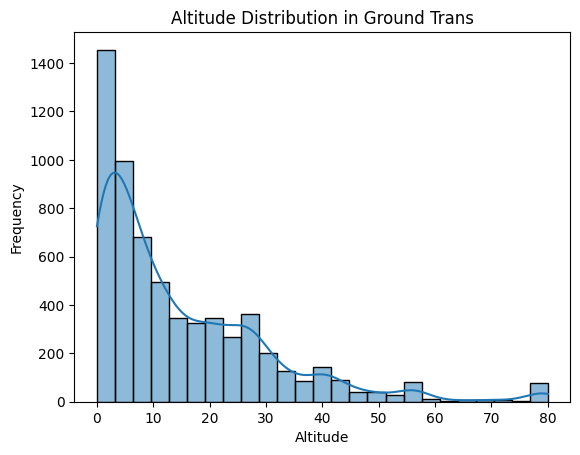

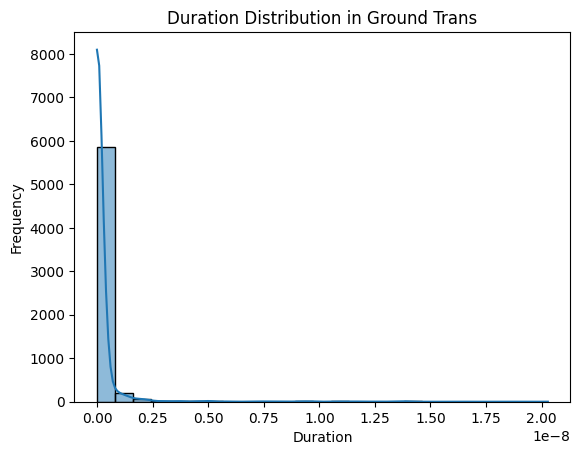

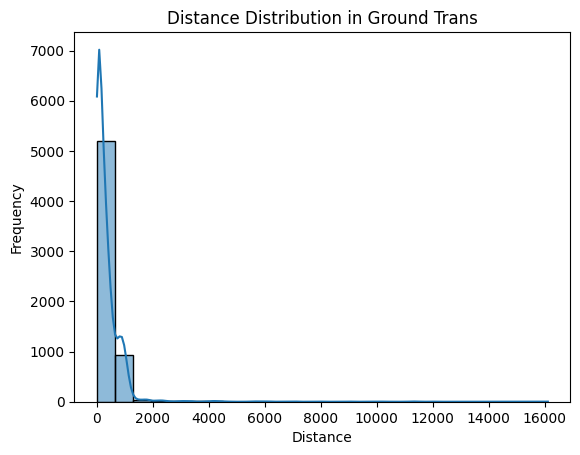

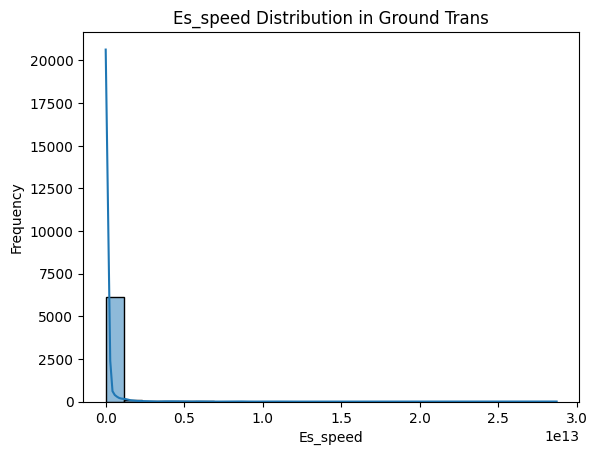

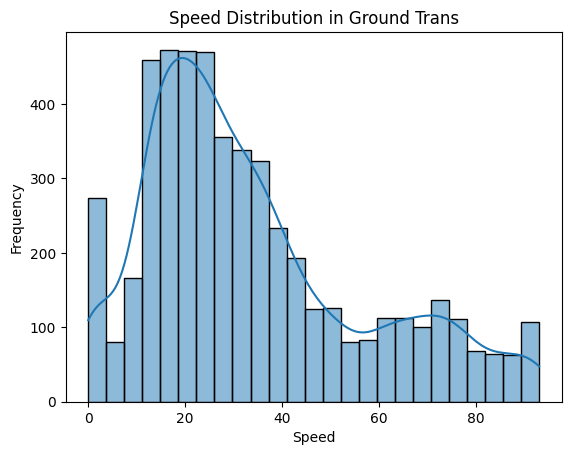

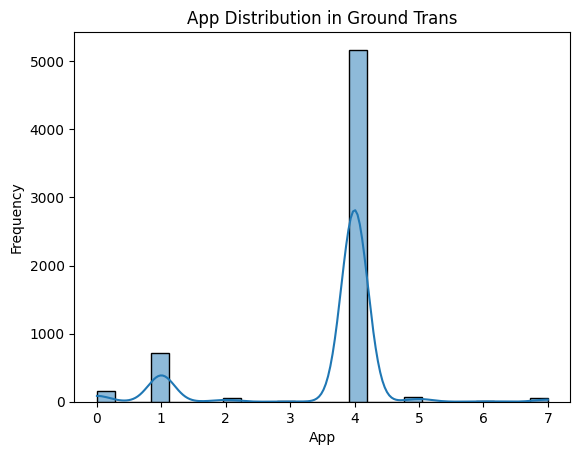

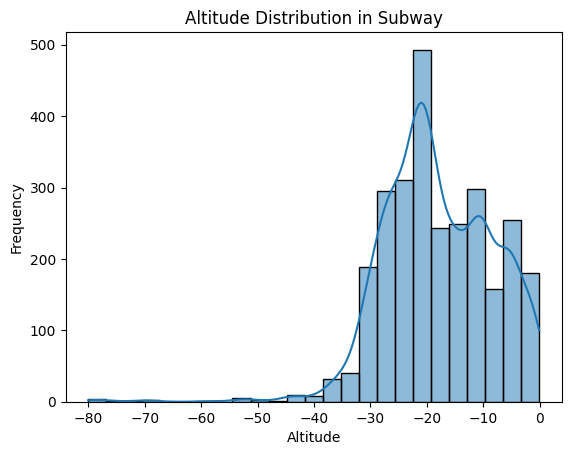

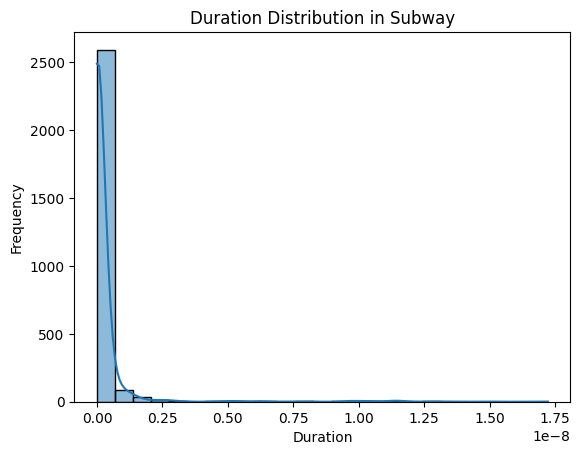

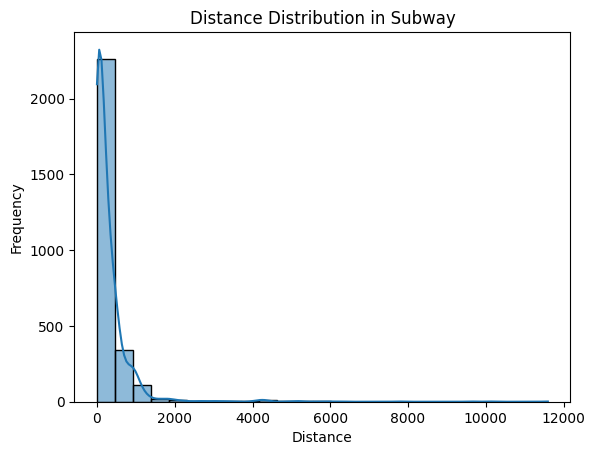

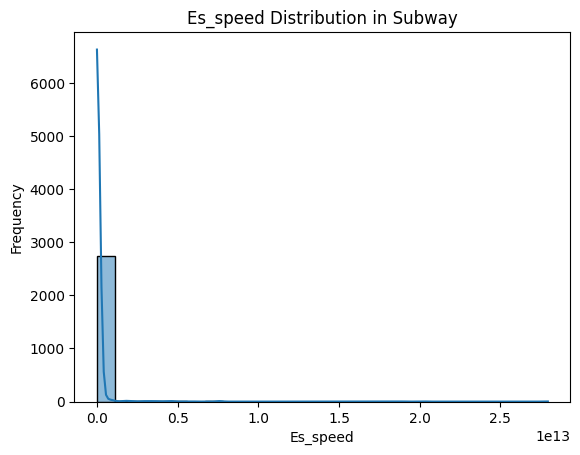

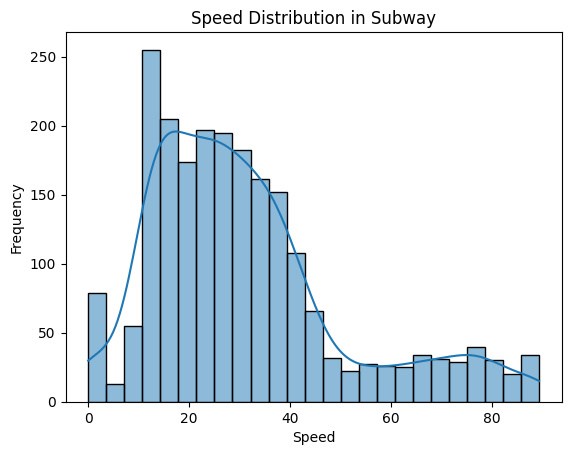

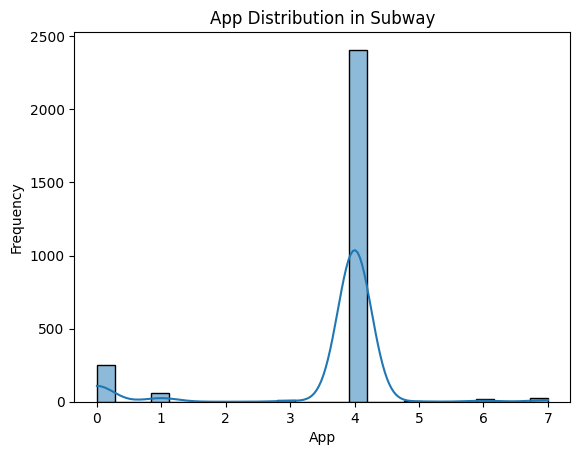

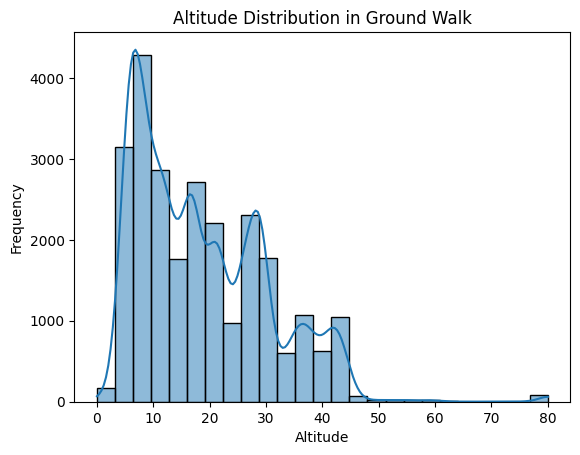

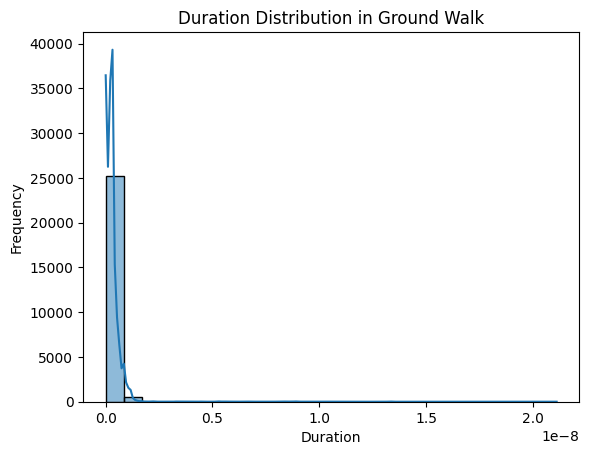

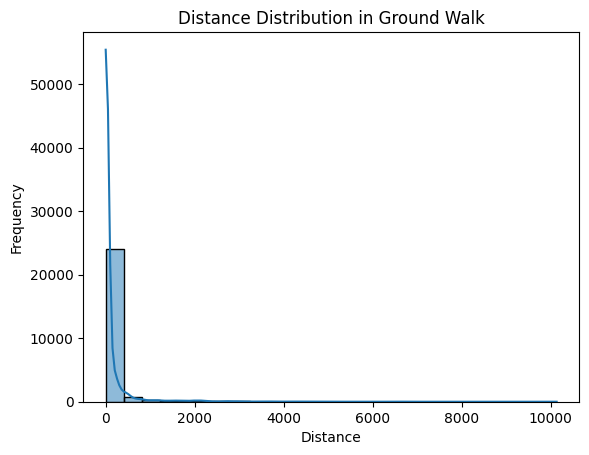

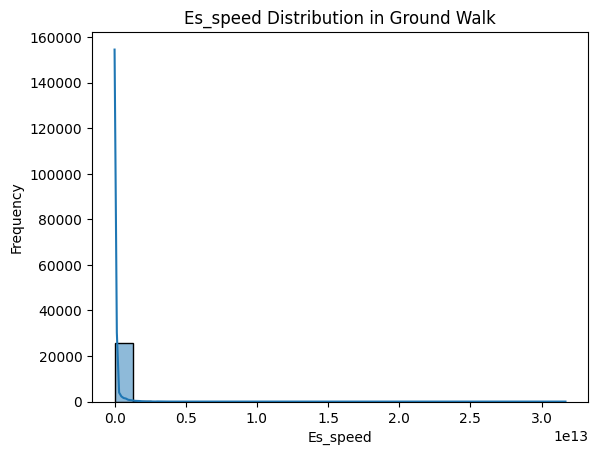

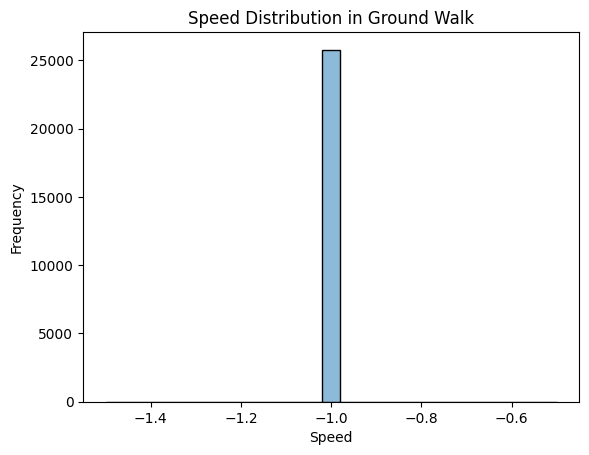

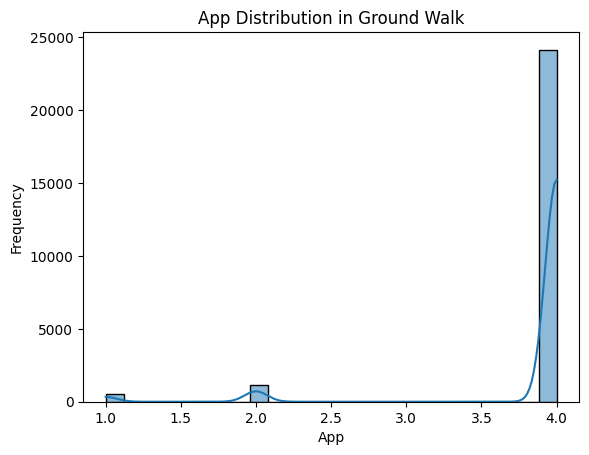

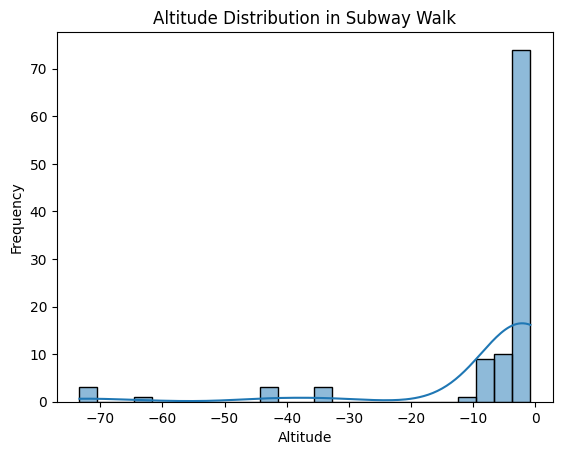

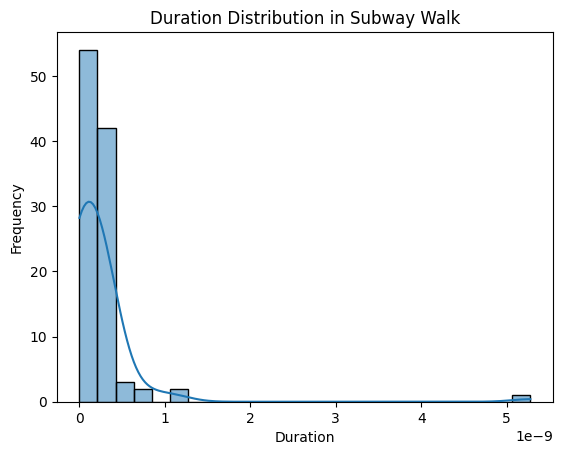

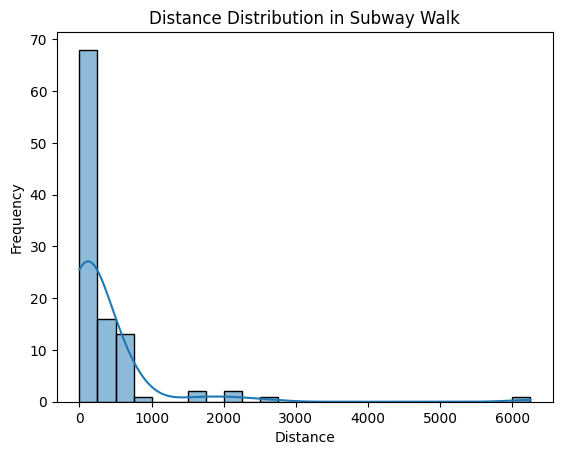

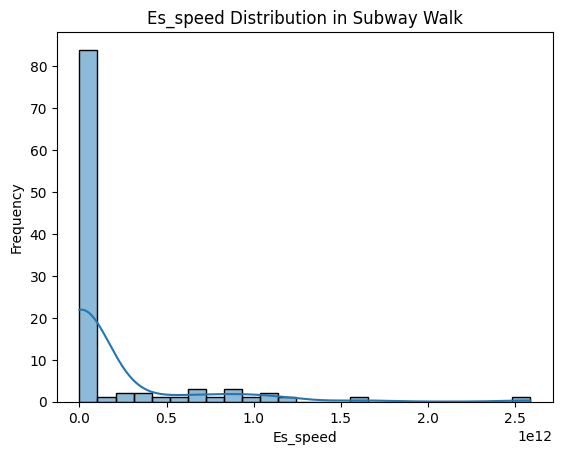

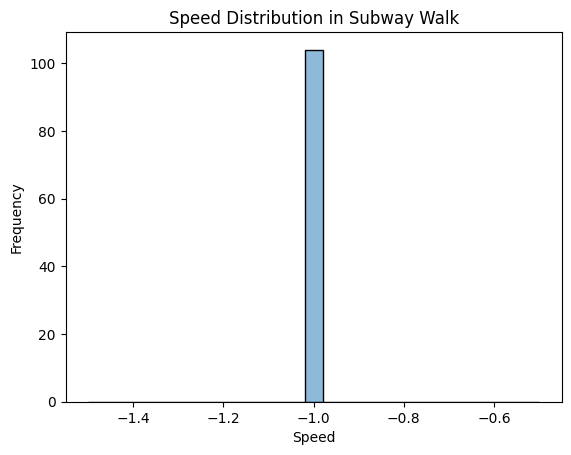

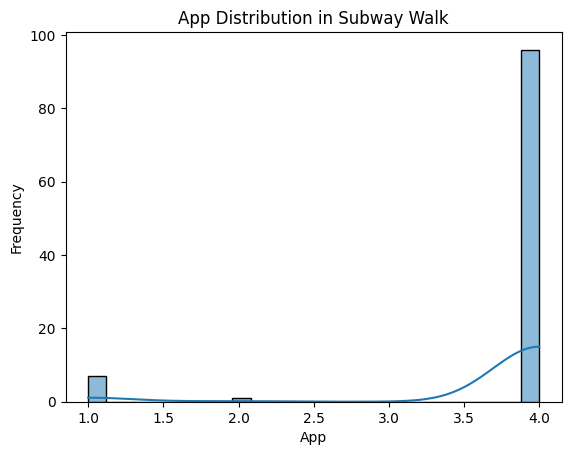

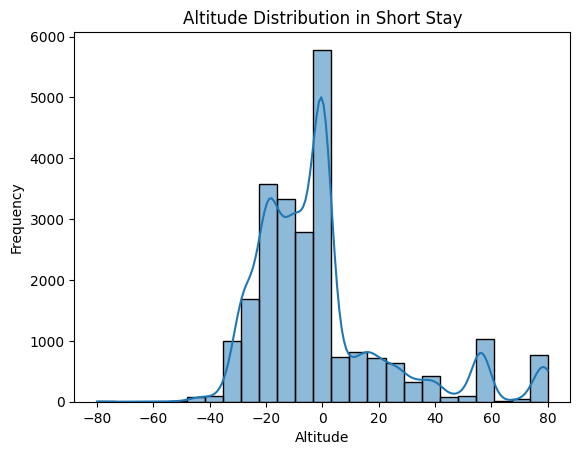

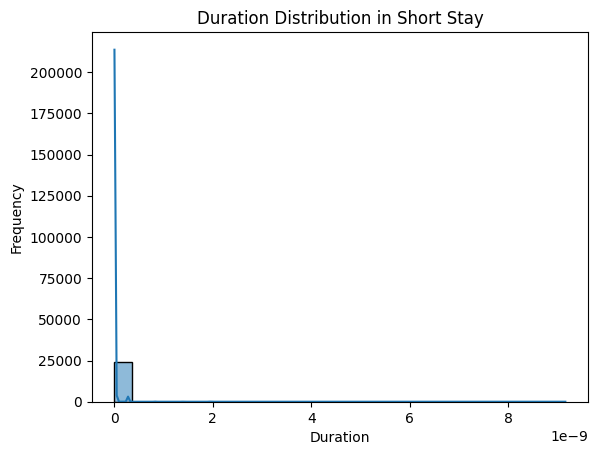

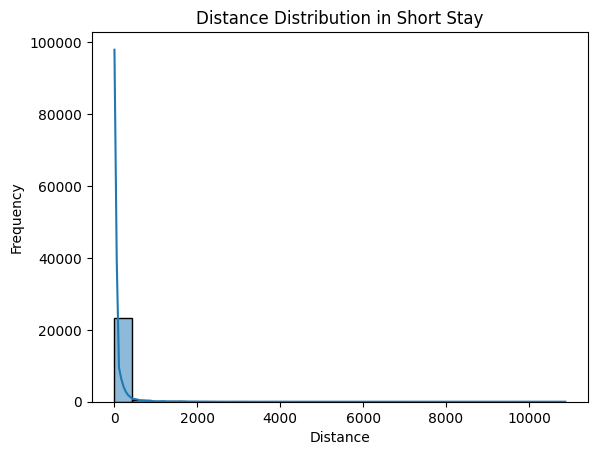

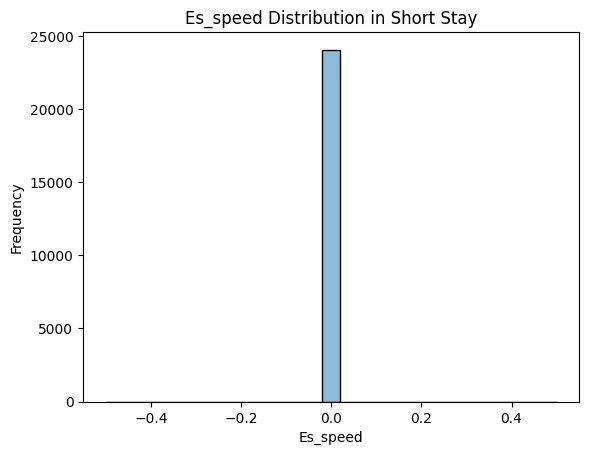

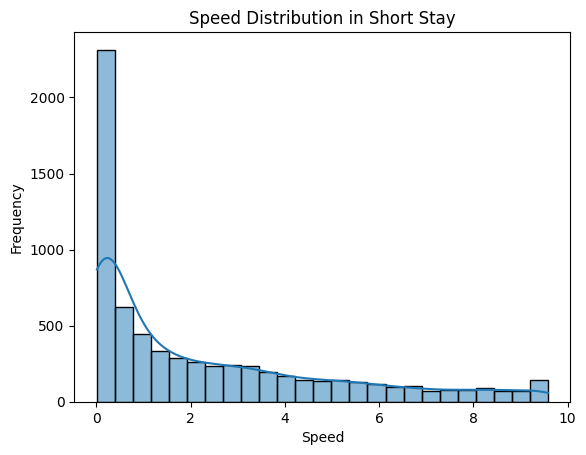

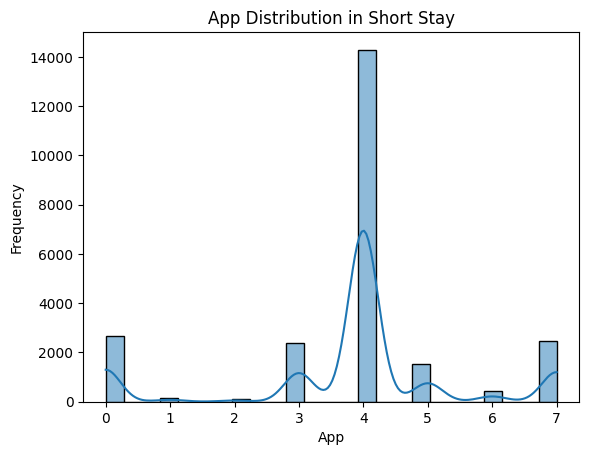

In [19]:
def main():
    state_dict = {"Ground Trans": {}, "Subway": {}, "Ground Walk": {}, "Subway Walk": {}, "Long Stay": {}, "Short Stay": {}}
    day_counter = 1
    dateslots = ["02-08", "02-09"] + ["02-" + str(_i) for _i in range(10, 22)]
    for dateslot in dateslots:
        data_df = load_data()
        data_df = add_time_token(data_df)
        print(dateslot)
        for user_group in data_df.groupby('advertiser_id'):
            user = user_group[0]
            group_df = user_group[1]
            group_df = group_df[group_df['day'] == day_counter]
            group_df = group_df.sort_values(by=['location_at'])
            group_df = group_df.reset_index()
            plot_traj(group_df, user, dateslot)
            state_analyse(group_df, state_dict, user)
        day_counter += 1

    print("======================State analysis============================")
    for state in state_dict:
        print(state)
        show_state(state_dict[state], state)
    print("======================State analysis============================")
    
main()

### Analysis

The maps show that people who move around a lot are marked by more dots that cover a larger area. This means they go to many different places. On the other hand, people who don't travel as much have fewer dots close together on the map, showing they stay in a smaller area.

Also, when looking at the maps for different days, it's clear that people tend to travel more on weekdays. This is probably because they are going to work or running errands. The maps for these days have dots that are far apart, which means people are going to different places. On weekends, there aren't as many dots and they're not spread out much, which suggests that people stay closer to home and don't travel as much.

The distance and duration histograms indicate that most "Ground Trans" states have short durations and cover smaller distances, with a sharp drop-off as the values increase. This is indicative of a pattern of short trips or segments which is common in urban travel where distances between stops are not large, and travel time can be brief.

The speed histogram shows that most observations have a speed close to zero, which is expected in a "Short Stay" state where users are presumably stationary or moving minimally. The es_speed histogram reinforces this finding, with the vast majority of estimated speeds being zero. However, there are some non-zero speeds, although very low, which could be due to minor positional adjustments or GPS noise.
Thiste is characterized by very low or zero movement, as indicated by the dominance of zero speed and estimated speed values
n: There's a clear distinction between movement-related states and the "Short Stay" state, which can be useful for applications that rely on user activity levels, such as fitness trackers or contextual advertising.
